In [49]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
# Importing the keras library and the TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Importing the necessary libraries to create/construct the deep neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense ,Dropout
from tensorflow.keras import initializers
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Importing the Beer Sales Dataset as pandas dataframe
dataset=pd.read_csv('data1.csv')

In [51]:
# Column renaming
dataset.rename(columns={'wqi':'water_quality_index'},inplace=True)
dataset.rename(columns={'dates':'DATE'},inplace=True)
dataset.head(5)

,DATE,water_quality_index
0,4/29/1986,62.0
1,5/19/1986,64.0
2,6/18/1986,67.0
3,7/24/1986,68.0
4,8/15/1986,68.0


In [52]:
# 'DATE' column is converted from 'object' data type to 'datetime' 
dataset['DATE'] = pd.to_datetime(dataset['DATE'])
# Feature Engineering is applied to extract the Months and Years from the 'DATE' column
dataset['Year'] = dataset['DATE'].apply(lambda date:date.year)
dataset['Month'] = dataset['DATE'].apply(lambda date:date.month)
dataset.head(2)

,DATE,water_quality_index,Year,Month
0,1986-04-29,62.0,1986,4
1,1986-05-19,64.0,1986,5


In [53]:
# 'DATE' column is set as dataset index
dataset=dataset.set_index(['DATE'])
dataset.head(2)

,water_quality_index,Year,Month
DATE,,,
1986-04-29,62.0,1986,4
1986-05-19,64.0,1986,5


In [54]:
# Mapping to rename the entries of the 'Month' column
num_to_name={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',
                                  6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
dataset['Month'] = dataset['Month'].map(num_to_name)
dataset.head(2)

,water_quality_index,Year,Month
DATE,,,
1986-04-29,62.0,1986,Apr
1986-05-19,64.0,1986,May


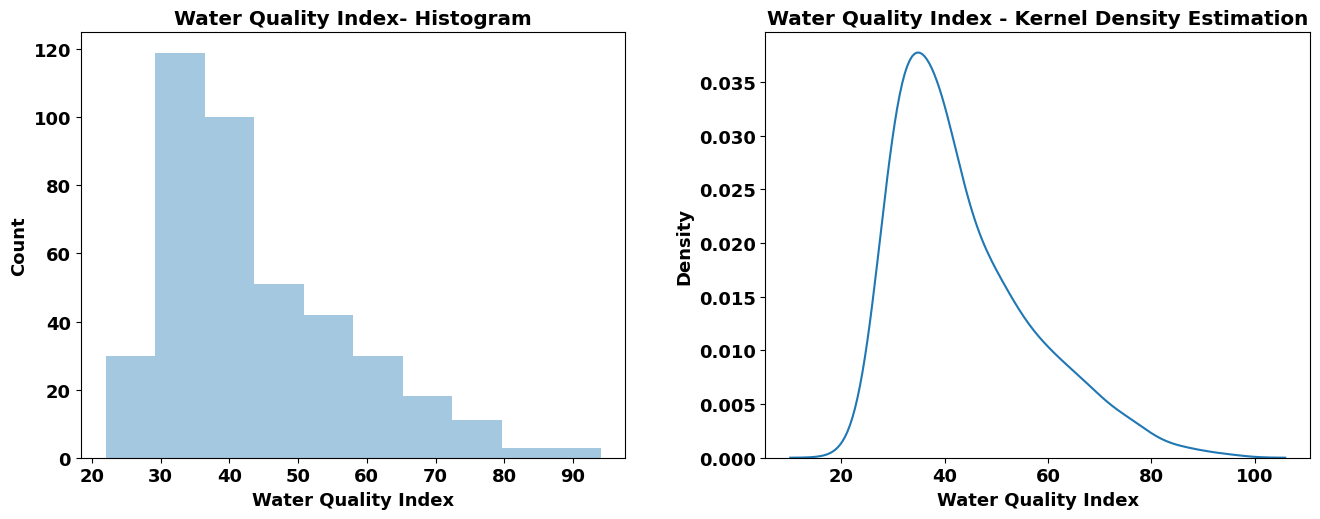

In [55]:
# Water quality index histogram and kernel density estimation plots
fig,axs=plt.subplots(1,2,figsize=(14,6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=12

sns.distplot(dataset['water_quality_index'],kde=False,bins=10,ax=axs[0])
axs[0].set_title('Water Quality Index- Histogram',fontweight='bold')
axs[0].set_xlabel('Water Quality Index',fontweight='bold')
axs[0].set_ylabel('Count',fontweight='bold')

sns.distplot(dataset['water_quality_index'],kde=True,hist=False,ax=axs[1])
axs[1].set_title('Water Quality Index - Kernel Density Estimation',fontweight='bold')
axs[1].set_xlabel('Water Quality Index',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold')

for ax in axs.flat:
    
    ax.figure.tight_layout(pad=3);

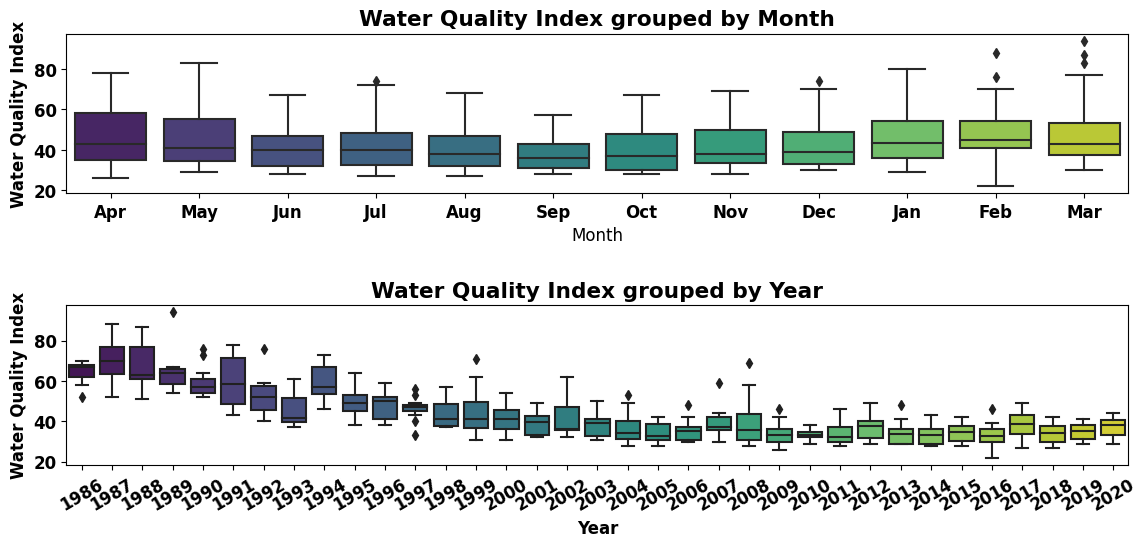

In [56]:
# Boxplots of Water quality index grouped by Month and Year. Based on the 'Months' boxplot, it can be observed that
fig,axs=plt.subplots(2,1,figsize=(12,6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13


sns.boxplot(x='Month',data=dataset,y='water_quality_index',palette='viridis',ax=axs[0])
axs[0].set_ylabel('Water Quality Index',fontweight='bold')
axs[0].set_title('Water Quality Index grouped by Month',fontweight='bold')
sns.boxplot(ax=axs[1],x='Year',data=dataset,y='water_quality_index',palette='viridis')
axs[1].set_xlabel('Year',fontweight='bold')
axs[1].set_ylabel('Water Quality Index',fontweight='bold')
axs[1].set_title('Water Quality Index grouped by Year',fontweight='bold')

plt.setp(axs[1].get_xticklabels(), rotation=30)
for ax in axs.flat:
   
    ax.figure.tight_layout(pad=2)

In [57]:
# Dropping the 'Year', 'Month' columns
data=dataset.drop(['Year','Month'],axis=1)
data.head()

,water_quality_index
DATE,
1986-04-29,62.0
1986-05-19,64.0
1986-06-18,67.0
1986-07-24,68.0
1986-08-15,68.0


Text(0.5, 1.0, 'Water Quality Index Time Series')

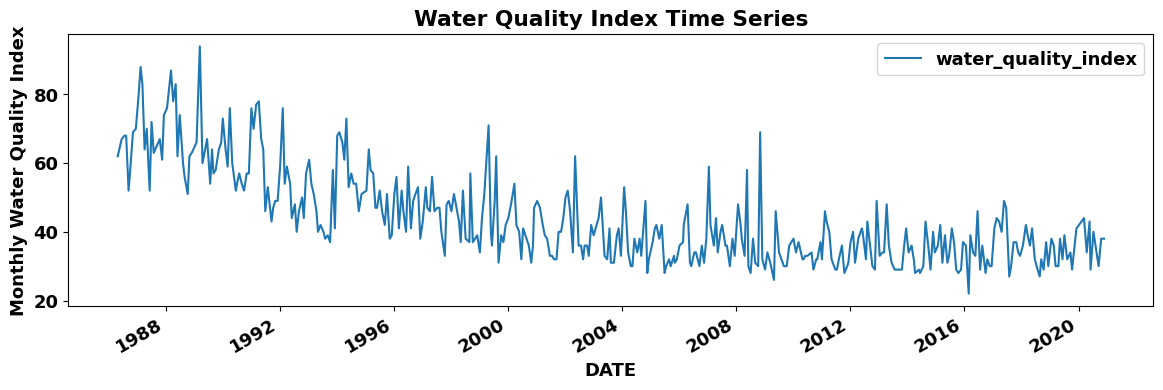

In [58]:
# Time Series Plot
data.plot(figsize=(14,4))
plt.xlabel('DATE',fontweight='bold')
plt.ylabel('Monthly Water Quality Index',fontweight='bold');
plt.title('Water Quality Index Time Series',fontweight='bold')

In [59]:
# Test size: 48 months
test_size = 48
# Dataset is split into training and test data
train = data.iloc[:len(dataset)- test_size]
test = data.iloc[-test_size:]

In [60]:
# Scaling the training and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Test size: 48 months
test_size = 48
# Dataset is split into training and test data
train = data.iloc[:len(dataset)- test_size]
test = data.iloc[-test_size:]
scaler.fit(data)
scaled_train = scaler.transform(data)
scaled_test = scaler.transform(test)

In [61]:
# Training Batch length
length = 47
# No. of features
n_features=1
# Creating the time series generator
time_series_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=10)

In [62]:
# First batch of the time_series_generator- training and test values
InpSeq,TargetVal=time_series_generator[0]

**CNN Training**

In [63]:
# Use of random seed to get the same results at every run
tf.random.set_seed(0)
np.random.seed(0)

# Use of the he_uniform initializer to set the initial random weights of the model layers. 
initializer = tf.keras.initializers.he_uniform(seed=0)

# Initially, the network model is defined 
model = Sequential()

# CNN
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(length, n_features),kernel_initializer=initializer))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
# The output layer consists of 1 neuron with a 'linear' activation fuction 
model.add(Dense(1,activation='linear',kernel_initializer=initializer))
# The model is compiled using MSE as  loss function and Adam as optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

# A validation generator is constructed in a similar way to the previous time_series_generator with the only difference being
# the use of scaled_test values for validation purposes
time_series_val_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=10)
# Début du chrono
start_time_forcasting_cnn = time.time()
# The model is trained for 1500 epochs. At each epoch both training and validation losses can be observed
model.fit_generator(time_series_generator,epochs=1000,shuffle=False,
                    validation_data=time_series_val_generator) 
# Fin du chrono
end_time_forcasting_cnn = time.time()

Epoch 1/1000
36/36 [==============================] - 2s 28ms/step - loss: 0.0891 - val_loss: 0.0012
Epoch 2/1000
36/36 [==============================] - 1s 20ms/step - loss: 0.0114 - val_loss: 0.0035
Epoch 3/1000
36/36 [==============================] - 1s 21ms/step - loss: 0.0099 - val_loss: 0.0047
Epoch 4/1000
36/36 [==============================] - 1s 31ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 5/1000
36/36 [==============================] - 1s 26ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 6/1000
36/36 [==============================] - 1s 27ms/step - loss: 0.0080 - val_loss: 0.0034
Epoch 7/1000
36/36 [==============================] - 1s 21ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 8/1000
36/36 [==============================] - 1s 21ms/step - loss: 0.0068 - val_loss: 0.0048
Epoch 9/1000
36/36 [==============================] - 1s 21ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 10/1000
36/36 [==============================] - 1s 21ms/step - loss: 0.0056 - val_lo

In [64]:
# Calcul de la durée d'entraînement en secondes
training_time_forcasting_cnn = end_time_forcasting_cnn - start_time_forcasting_cnn
# Affichage de la durée d'entraînement
print("Le temps d'entraînement est de", training_time_forcasting_cnn, "secondes")

Le temps d'entraînement est de 1197.3289604187012 secondes


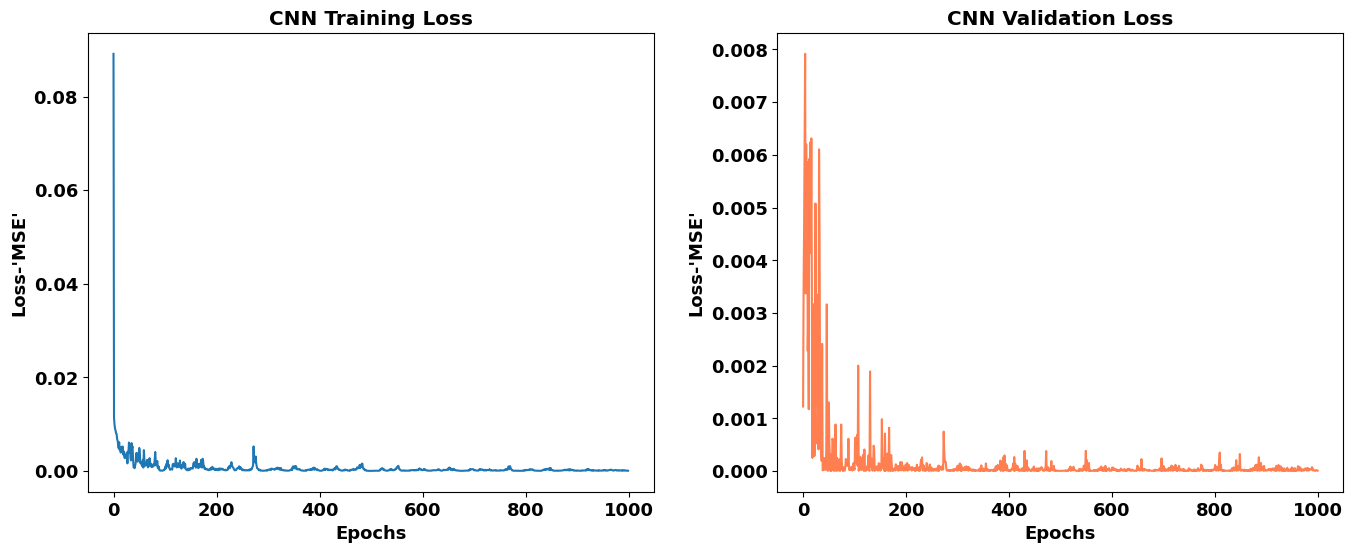

In [65]:
# Training and validation loss plots
fig,axs=plt.subplots(1,2,figsize=(14,6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=12
train_loss = pd.DataFrame(model.history.history)
train_loss.loss.plot(ax=axs[0])
axs[0].set_title('CNN Training Loss',fontweight='bold')
train_loss.val_loss.plot(ax=axs[1],color='coral')
axs[1].set_title('CNN Validation Loss',fontweight='bold')
for ax in axs.flat:
    ax.set_xlabel('Epochs',fontweight='bold')
    ax.set_ylabel("Loss-'MSE'",fontweight='bold')

   
    ax.figure.tight_layout(pad=2)

**CNN Predictions on the Training Set**

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('forcasting_wqi_hong_kong_using_cnn.h5')

In [66]:
# Determining all CNN outputs
training_outputs = []
batch = scaled_train[:length].reshape((1, length, n_features))

for i in range(len(scaled_train[:-length])):
    train_out = model.predict(batch)[0]
    training_outputs.append(train_out) 
    batch = np.append(batch[:,1:,:],[[scaled_train[:-length][i]]],axis=1)

#Inverse transforming the expected values
actual_train=scaled_train[:-length]
actual_train=scaler.inverse_transform(actual_train)
# Inverse transforming the CNN predictions on the training set
train_predictions=scaler.inverse_transform(training_outputs)

1/1 [==============================] - 0s 31ms/step


In [67]:
# Determining all CNN outputs 
test_outputs = []
batch = scaled_train[-length:].reshape((1, length, n_features))

for i in range(len(test)):
    test_out = model.predict(batch)[0]
    test_outputs.append(test_out) 
    batch = np.append(batch[:,1:,:],[[test_out]],axis=1)
# Inverse transforming the CNN predicitons
cnn_predictions = scaler.inverse_transform(test_outputs)
# A new test feature is created to comprise the CNN test predictions
test['CNN Predictions'] = cnn_predictions.round(2)

1/1 [==============================] - 0s 22ms/step


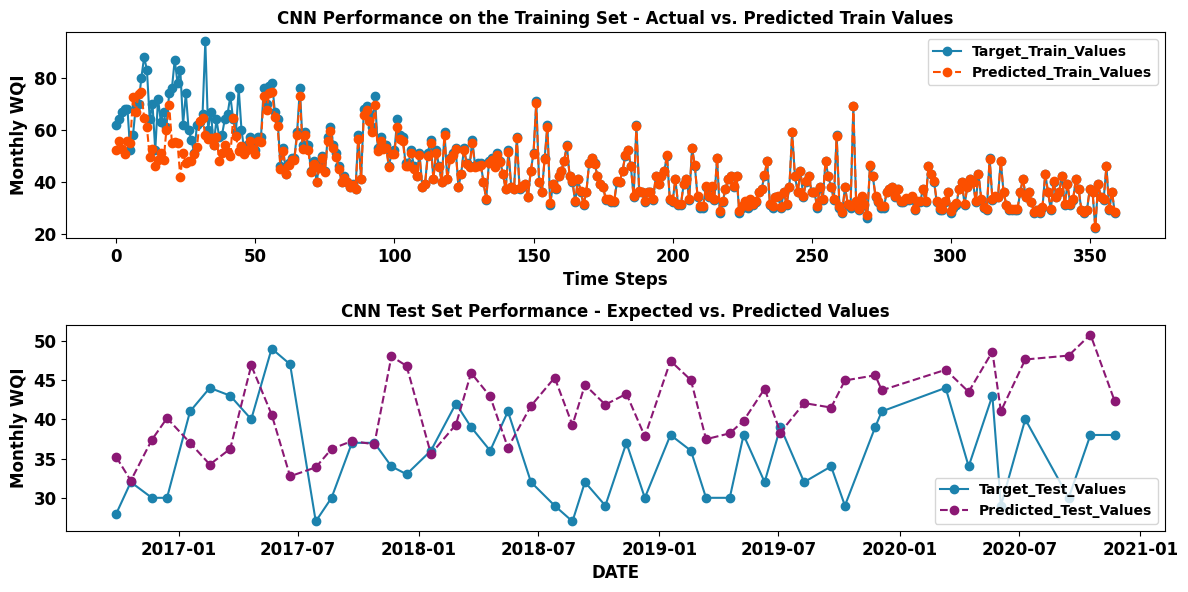

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size'] = 10

# Plotting the training set
axs[0].plot(actual_train, marker='o', linestyle='-', label='Target_Train_Values',color='#1C82AD')
axs[0].plot(train_predictions, marker='o', linestyle='dashed', label='Predicted_Train_Values',color='#FC4F00')

# Plotting the test set
axs[1].plot(test['water_quality_index'], marker='o', linestyle='-', label='Target_Test_Values',color='#1C82AD')
axs[1].plot(test['CNN Predictions'], marker='o', linestyle='dashed', label='Predicted_Test_Values',color='#8B1874')

# Adding titles and labels to the plots
axs[0].set_title('CNN Performance on the Training Set - Actual vs. Predicted Train Values', fontweight='bold')
axs[0].set_xlabel('Time Steps', fontweight='bold')
axs[0].set_ylabel('Monthly WQI', fontweight='bold')
axs[0].legend()

axs[1].set_title('CNN Test Set Performance - Expected vs. Predicted Values',fontweight='bold')
axs[1].set_xlabel('DATE', fontweight='bold')
axs[1].set_ylabel('Monthly WQI', fontweight='bold')
axs[1].legend()

fig.tight_layout(pad=1)

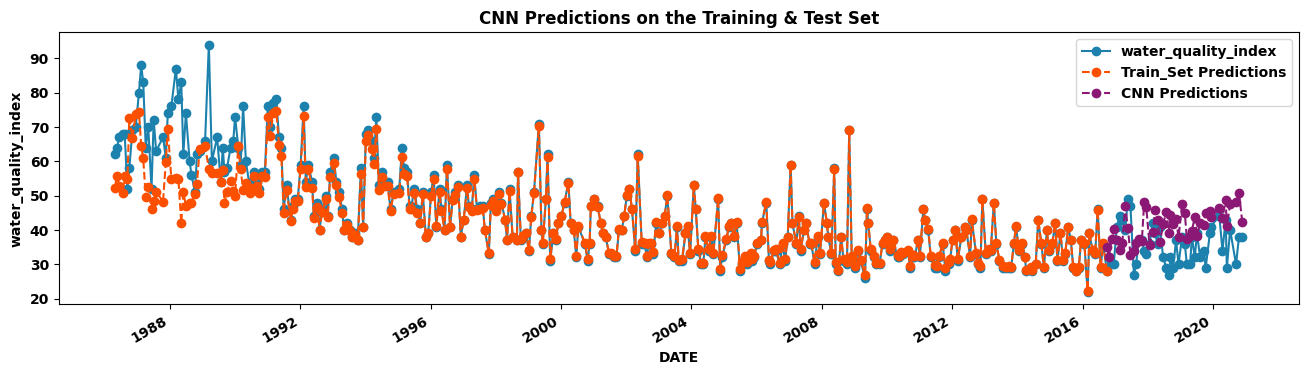

In [69]:
# Convertir le tableau train_predictions en DataFrame Pandas
train_df = pd.DataFrame(data=train_predictions, index=data.index[:-length], columns=['Train_Set Predictions'])
# Tracer le graphique en utilisant les données d'origine, les prévisions du modèle sur l'ensemble d'entraînement et les prévisions du modèle sur l'ensemble de test
ax = data.plot(figsize=(16,4), marker='o', linestyle='-',color='#1C82AD')
train_df.plot(ax=ax, marker='o', linestyle='--', legend=True,color='#FC4F00')
test['CNN Predictions'].plot(ax=ax, legend=True, marker='o', linestyle='dashed',color='#8B1874')

# Personnaliser le graphique
plt.title('CNN Predictions on the Training & Test Set', fontweight='bold')
plt.ylabel('water_quality_index', fontweight='bold')
plt.xlabel('DATE', fontweight='bold')
plt.show()

**Monthly WQI future forecast using CNN**

In [70]:
# A new scaler is being initialized
data_scaler=MinMaxScaler()
# fit_transform function applied to all dataset's entries
data_scaler.fit_transform(data)
# Creating an index for the LSTM predictions on the Training Set
f_train_index=pd.date_range(start='1986-04-29',periods=360,freq='M')
# Converting the LSTM predictions from np.ndarray to pandas dataframe
f_train_df=pd.DataFrame(data=train_predictions,index=f_train_index,columns=['Predicted_Train'])
# Obtaining the CNN forecasted values 
cnn_outputs=[]
batch = scaled_train[-length:].reshape((1, length, n_features))

for i in range(length):
    cnn_out = model.predict(batch)[0]
    cnn_outputs.append(cnn_out) 
    batch = np.append(batch[:,1:,:],[[cnn_out]],axis=1)
# Inverse transforming the LSTM forecasts
cnn_outputs=data_scaler.inverse_transform(cnn_outputs)

1/1 [==============================] - 0s 40ms/step


Text(0.5, 0, ' DATE')

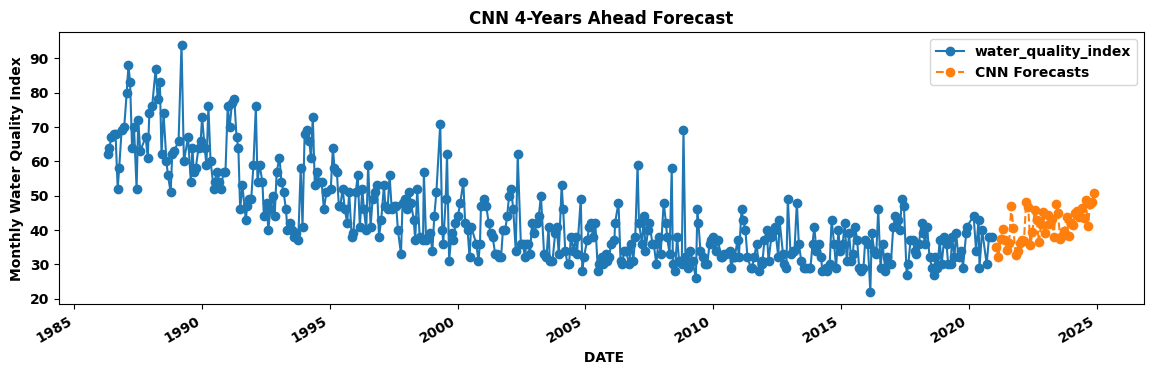

In [71]:
# Creating an index for the CNN forecasts
cnn_forecast_index=pd.date_range(start='2021-01-01',periods=47,freq='M')
# Converting the cnn_outputs from np.ndarray to pandas dataframe
cnn_forecast_df=pd.DataFrame(data=cnn_outputs,index=cnn_forecast_index,columns=['CNN Forecasts'])
# Plot comprising the original time series,and the 48-month CNN forecasts
ax=data.plot(figsize=(14,4),marker='o',linestyle='-')
cnn_forecast_df.plot(ax=ax,marker='o',linestyle='--')
plt.title('CNN 4-Years Ahead Forecast',fontweight='bold')
plt.ylabel('Monthly Water Quality Index',fontweight='bold')
plt.xlabel(' DATE',fontweight='bold')

**ERRORS**

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
# Supposons que vous ayez deux tableaux de valeurs réelles et prédites
y_true = test['water_quality_index']
y_pred = test['CNN Predictions']
# Calcul de l'erreur MSE
mse = mean_squared_error(y_true, y_pred)
# Calcul de l'erreur MAE
mae = mean_absolute_error(y_true, y_pred)
# Calcul de l'erreur MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Calcul de l'erreur RMSE
rmse = np.sqrt(mse)
# Calcul de l'erreur RMAE
rmae = np.sqrt(mae)
#calculer r_square
r_square, _ = pearsonr(y_true, y_pred)
# Affichage des résultats
print("Mean square error:", mse)
print("Mean absolute error:", mae)
print("Mean absolute persontage error:", mape)
print("Root mean square error:", rmse)
print("Root mean absolute error:", rmae)
print("Pearsons Correlation Coefficient:", r_square)

Mean square error: 45.87335208333334
Mean absolute error: 5.779374999999999
Mean absolute persontage error: 17.02839951440125
Root mean square error: 6.772986939551363
Root mean absolute error: 2.4040330696560726
Pearsons Correlation Coefficient: -0.15774014757842691
